In [1]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/hminle/miniconda2/e

In [2]:
from datetime import datetime
from bisect import bisect_right, bisect_left
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

## Explore Data

In [4]:
employee_df = pd.read_csv('./data/employee_retention_data.csv')

In [5]:
employee_df.head()

employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22

In [6]:
employee_df.isna().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

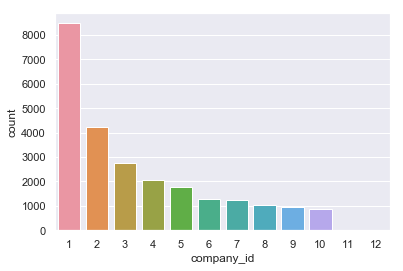

In [7]:
sns.countplot(x='company_id', data=employee_df)

## Find the headcount

In [8]:
grouped_df = employee_df.groupby('company_id')

In [60]:
list_df = []
for name, group in grouped_df:
    print('Handle company_id {}'.format(name))
    group_join_date_count = group.groupby('join_date', as_index=False).count()
    group_join_date_count = group_join_date_count[['join_date', 'employee_id']]
    group_join_date_count = group_join_date_count.rename(index=str, columns={'employee_id': 'count_join_date',
                                                                             'join_date': 'date'})
    
    group_quit_date_count = group.groupby('quit_date', as_index=False).count()
    group_quit_date_count = group_quit_date_count[['quit_date', 'employee_id']]
    group_quit_date_count = group_quit_date_count.rename(index=str, columns={'employee_id': 'count_quit_date',
                                                                              'quit_date': 'date'})
    company_merge = pd.merge(group_join_date_count, group_quit_date_count, on='date', how='outer').fillna(0)
    company_merge['count_join_cumsum'] = company_merge['count_join_date'].cumsum()
    company_merge['count_quit_cumsum'] = company_merge['count_quit_date'].cumsum()
    # headcount_company = 'employee_headcount_company_{}'.format(name)
    company_merge['employee_headcount'] = company_merge['count_join_cumsum'] - company_merge['count_quit_cumsum']
    del company_merge['count_join_date']
    del company_merge['count_quit_date']
    del company_merge['count_join_cumsum']
    del company_merge['count_quit_cumsum']
    company_merge = company_merge.assign(company_id=name)
    list_df.append(company_merge)

Handle company_id 1
Handle company_id 2
Handle company_id 3
Handle company_id 4
Handle company_id 5
Handle company_id 6
Handle company_id 7
Handle company_id 8
Handle company_id 9
Handle company_id 10
Handle company_id 11
Handle company_id 12


In [61]:
concatenated_df = pd.concat(list_df)

Text(0.5,1,'Employee_Headcount_Company_5')

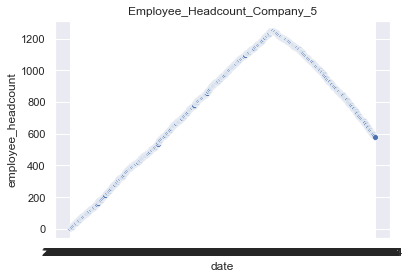

In [91]:
sns.scatterplot(x='date', y='employee_headcount', data=list_df[5])
plt.title('Employee_Headcount_Company_5')

## Find factors

In [73]:
employee_df.head(20)

employee_id  company_id              dept  seniority    salary  \
0       13021.0           7  customer_service         28   89000.0   
1      825355.0           7         marketing         20  183000.0   
2      927315.0           4         marketing         14  101000.0   
3      662910.0           7  customer_service         20  115000.0   
4      256971.0           2      data_science         23  276000.0   
5      509529.0           4      data_science         14  165000.0   
6       88600.0           4  customer_service         21  107000.0   
7      716309.0           2  customer_service          4   30000.0   
8      172999.0           9          engineer          7  160000.0   
9      504159.0           1             sales          7  104000.0   
10     892155.0           6  customer_service         13   72000.0   
11     904158.0           2         marketing         17  230000.0   
12     939058.0           1         marketing          1   48000.0   
13     163427.0          10         marketing         23  154000.0   
14     461248.0           2             sales         20  201000.0   
15     265226.0           1      data_science          4   80000.0   
16     932790.0           7         marketing         10   88000.0   
17      69693.0           7  customer_service          6   54000.0   
18     721600.0           2         marketing         20  193000.0   
19     982668.0           1  customer_service         14   76000.0   

     join_date   quit_date  isQuit  
0   2014-03-24  2015-10-30       1  
1   2013-04-29  2014-04-04       1  
2   2014-10-13         NaN       0  
3   2012-05-14  2013-06-07       1  
4   2011-10-17  2014-08-22       1  
5   2012-01-30  2013-08-30       1  
6   2013-10-21         NaN       0  
7   2014-03-05         NaN       0  
8   2012-12-10  2015-10-23       1  
9   2012-06-12         NaN       0  
10  2012-11-12  2015-02-27       1  
11  2015-05-11         NaN       0  
12  2012-12-10  2013-11-15       1  
13  2012-06-18  2015-09-25       1  
14  2013-09-16  2014-08-22       1  
15  2014-05-27  2015-07-10       1  
16  2011-11-30  2013-11-22       1  
17  2014-03-31         NaN       0  
18  2014-12-29         NaN       0  
19  2015-07-27         NaN       0

In [71]:
def isQuit(quit_date):
    if pd.isnull(quit_date):
        return 0
    else:
        return 1

In [72]:
employee_df['isQuit'] = employee_df.apply(lambda row: isQuit(row['quit_date']), axis=1)

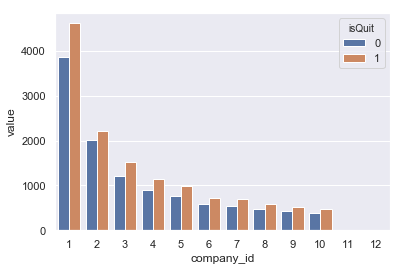

In [74]:
ct = pd.crosstab(employee_df['company_id'],employee_df['isQuit'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.company_id, y=stacked.value, hue=stacked['isQuit'])

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

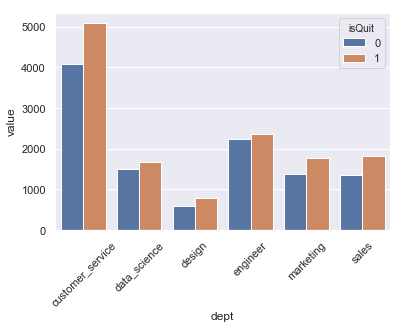

In [78]:
ct = pd.crosstab(employee_df['dept'],employee_df['isQuit'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.dept, y=stacked.value, hue=stacked['isQuit'])
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

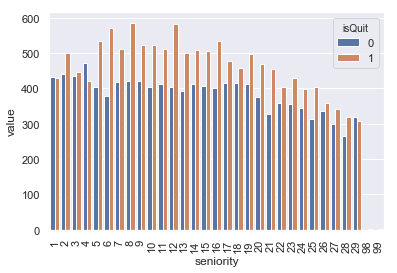

In [81]:
ct = pd.crosstab(employee_df['seniority'],employee_df['isQuit'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.seniority, y=stacked.value, hue=stacked['isQuit'])
plt.xticks(rotation=90)

In [83]:
def getSalaryRange(salary):
    if salary < 50000:
        return 'low'
    elif salary < 100000:
        return 'medium'
    elif salary < 150000:
        return 'high'
    else:
        return 'very_high'

In [84]:
employee_df['salary_range'] = employee_df.apply(lambda row: getSalaryRange(row['salary']), axis=1)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

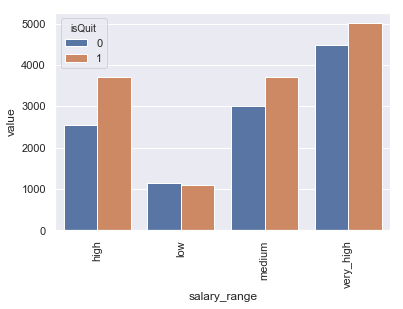

In [85]:
ct = pd.crosstab(employee_df['salary_range'],employee_df['isQuit'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.salary_range, y=stacked.value, hue=stacked['isQuit'])
plt.xticks(rotation=90)

## Report

I found out that: 
- company_id 1 has the most employee who quit their job, but also this company hire the most employees
- employees who work as customer service are more likely to quit their job
- employees who have very high salary (greater than 150k usd) are also likely to quit their job

If I can add one more variable. I would like to add 'off_days' according to employee_id.
I think if we know how many days they are off from the job, we can predict the result better.